In [81]:
from __future__ import annotations

import pickle
from collections import OrderedDict
from pathlib import Path

import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot
from hist import Hist

from boostedhh.hh_vars import data_key, years
from bbtautau.postprocessing.datacardHelpers import sum_templates
from bbtautau.postprocessing.postprocessing import shape_vars
from bbtautau.postprocessing import plotting
from bbtautau.postprocessing import utils as putils
from bbtautau.postprocessing.Samples import BGS, CHANNELS

In [82]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [83]:
folder = "25July31"
bmin = 8
use_bdt = True
tag = ["nobbttpresel_noNormSig_noBkgConstraint_ParT", "lowregBDT"][use_bdt]

plot_dir = Path("/home/users/lumori/bbtautau/plots/PostFit") / folder / tag / f"bmin_{bmin}"
plot_dir.mkdir(exist_ok=True, parents=True)

csv_dir = Path("/home/users/lumori/bbtautau/plots/SensitivityStudy/2025-07-31/full_presel/")

In [84]:
file = uproot.open(
    f"/home/users/lumori/bbtautau/src/bbtautau/cards/{folder}/{tag}/bmin_{bmin}/FitShapes.root"
)
templates_dir = f"templates/{folder}/{tag}/bmin_{bmin}"

In [85]:
# sig_templates_dir = Path(f"templates/25Apr23/{CHANNEL.key}")
# bg_templates_dir = Path(f"templates/25Apr23/{CHANNEL.key}")

# templates_dict = {}
# for year in years:
#     with (sig_templates_dir / f"{year}_templates.pkl").open("rb") as f:
#         templates_dict[year] = pickle.load(f)

# sig_pre_templates = sum_templates(templates_dict, years)

# templates_dict = {}
# for year in years:
#     with (bg_templates_dir / f"{year}_templates.pkl").open("rb") as f:
#         templates_dict[year] = pickle.load(f)

# bg_pre_templates = sum_templates(templates_dict, years)

In [86]:
def get_pre_templates(templates_dir):
    templates_dict = {}
    for year in years:
        with (templates_dir / f"{year}_templates.pkl").open("rb") as f:
            templates_dict[year] = pickle.load(f)

    return sum_templates(templates_dict, years)

In [87]:
workspace_data_key = "data_obs"

# (name in templates, name in cards)
hist_label_map_inverse = OrderedDict(
    [
        ("qcddy", "CMS_bbtautau_boosted_qcd_datadriven"),
        ("ttbarsl", "ttbarsl"),
        ("ttbarll", "ttbarll"),
        ("ttbarhad", "ttbarhad"),
        # ("dyjets", "dyjets"),
        ("wjets", "wjets"),
        ("zjets", "zjets"),
        ("hbb", "hbb"),
        (data_key, workspace_data_key),
    ]
)

hist_label_map = {val: key for key, val in hist_label_map_inverse.items()}

sig_keys = ["bbtt"]

# pbg_keys = [bk for bk in bg_keys if bk not in ["Diboson", "Hbb", "HWW"]]
pbg_keys = ["qcddy", "ttbarhad", "ttbarsl", "ttbarll", "wjets", "zjets", "hbb"]
samples = pbg_keys + sig_keys + [data_key]

In [88]:
shapes = {
    "prefit": "Pre-Fit",
    # "shapes_fit_s": "S+B Post-Fit",
    "postfit": "B-only Post-Fit",
}

In [89]:
selection_regions = {}
for channel in CHANNELS.values():
    selection_regions[f"{channel.key}pass"] = f"{channel.label} Pass"
    selection_regions[f"{channel.key}fail"] = f"{channel.label} Fail"

In [90]:
hists = {}
bgerrs = {}

for shape in shapes:
    print(shape)
    hists[shape] = {
        region: Hist(
            hist.axis.StrCategory(samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="double",
        )
        for region in selection_regions
    }
    bgerrs[shape] = {}

    for region in selection_regions:
        h = hists[shape][region]
        templates = file[f"{region}_{shape}"]
        for key, file_key in hist_label_map_inverse.items():
            if key != data_key:
                if file_key not in templates:
                    print(f"No {key} in {region}")
                    continue

                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = templates[file_key].values()

        # # if key not in fit output, take from templates
        # for key in pbg_keys:
        #     if key not in hist_label_map_inverse:
        #         data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
        #         h.view(flow=False)[data_key_index, :] = bg_pre_templates[region][key, ...].values()

        # if key not in fit output, take from templates
        for key in sig_keys:
            if key not in hist_label_map_inverse:
                sig_pre_templates = get_pre_templates(Path(f"{templates_dir}/{region[:2]}"))
                data_key_index = np.where(np.array(list(h.axes[0])) == key)[0][0]
                h.view(flow=False)[data_key_index, :] = sig_pre_templates[region[2:]][
                    key + region[:2], ...
                ].values()

        data_key_index = np.where(np.array(list(h.axes[0])) == data_key)[0][0]
        h.view(flow=False)[data_key_index, :] = np.nan_to_num(
            templates[hist_label_map_inverse[data_key]].values()
        )

        bgerrs[shape][region] = np.minimum(
            templates["TotalBkg"].errors(), templates["TotalBkg"].values()
        )

prefit
No wjets in hhpass
No wjets in hmpass
No ttbarhad in hepass
No wjets in hepass
postfit
No wjets in hhpass
No wjets in hmpass
No ttbarhad in hepass
No wjets in hepass


In [91]:
# if not unblinded:
#     for shapeh in hists.values():
#         for region, h in shapeh.items():
#             if region != "fail":
#                 utils.blindBins(h, [100, 150], data_key, axis=0)

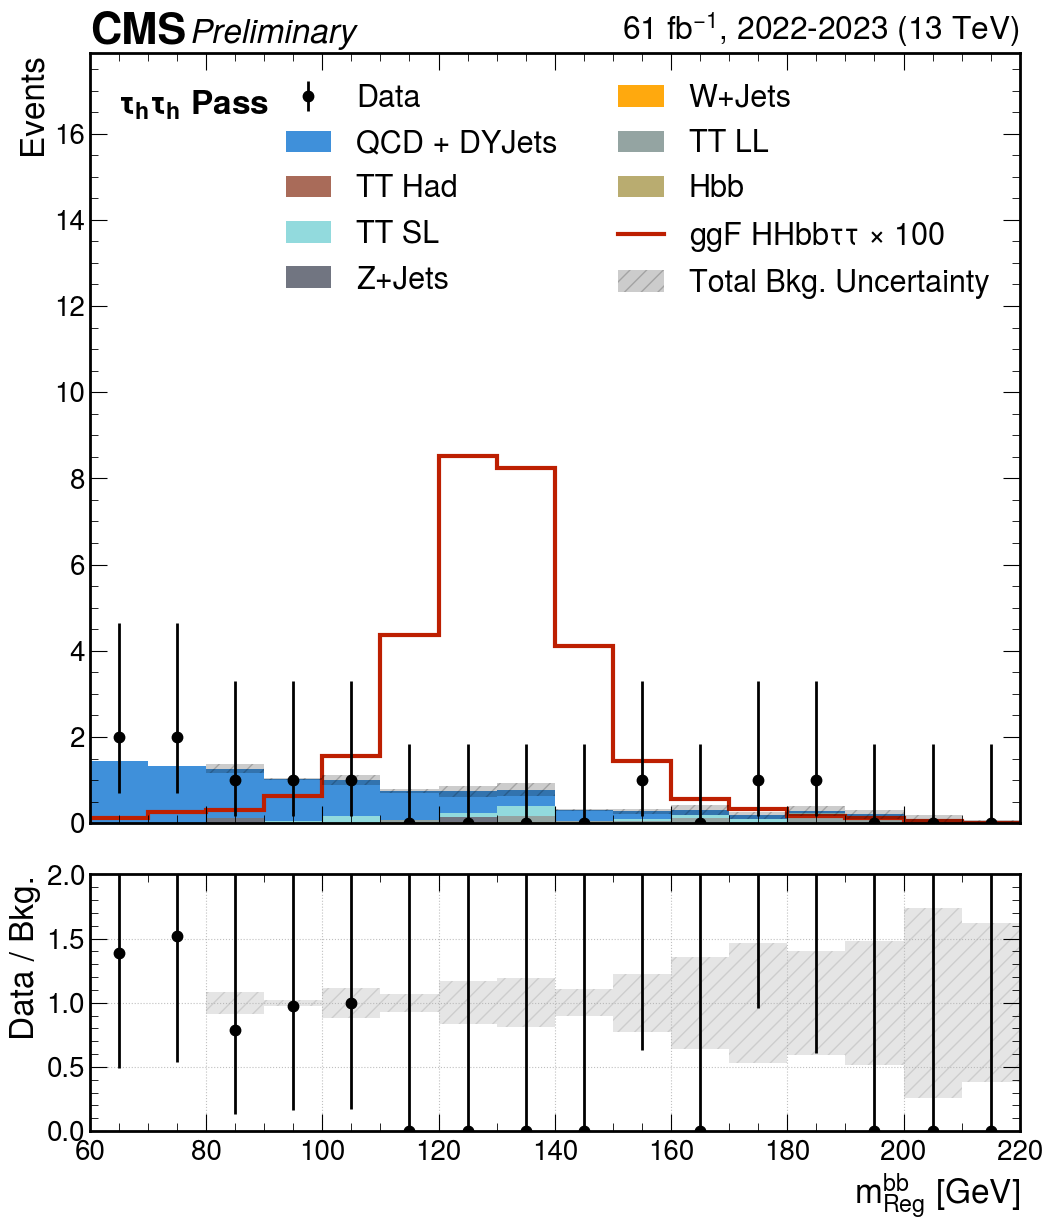

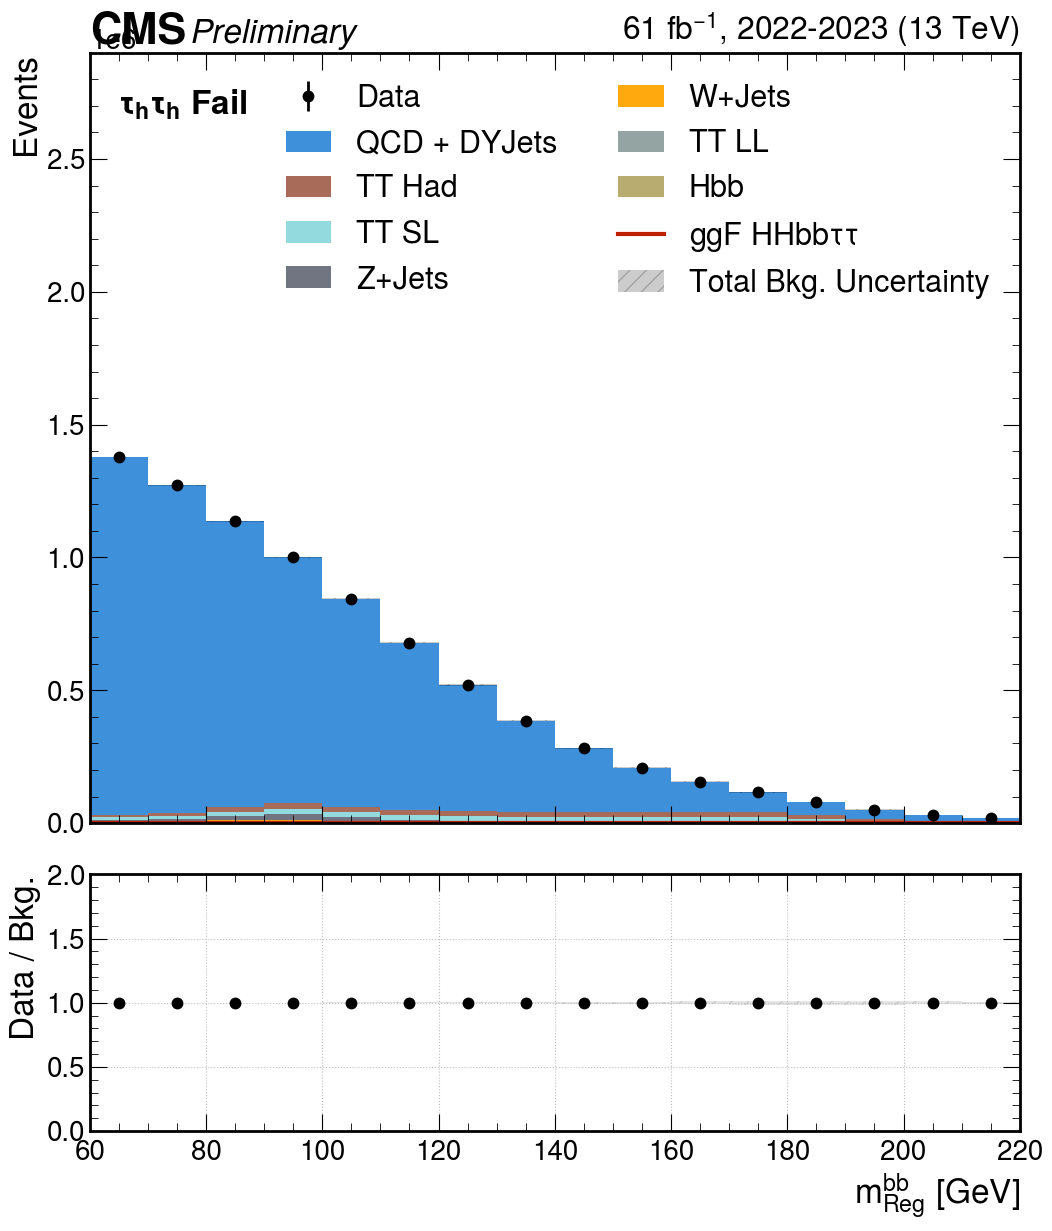

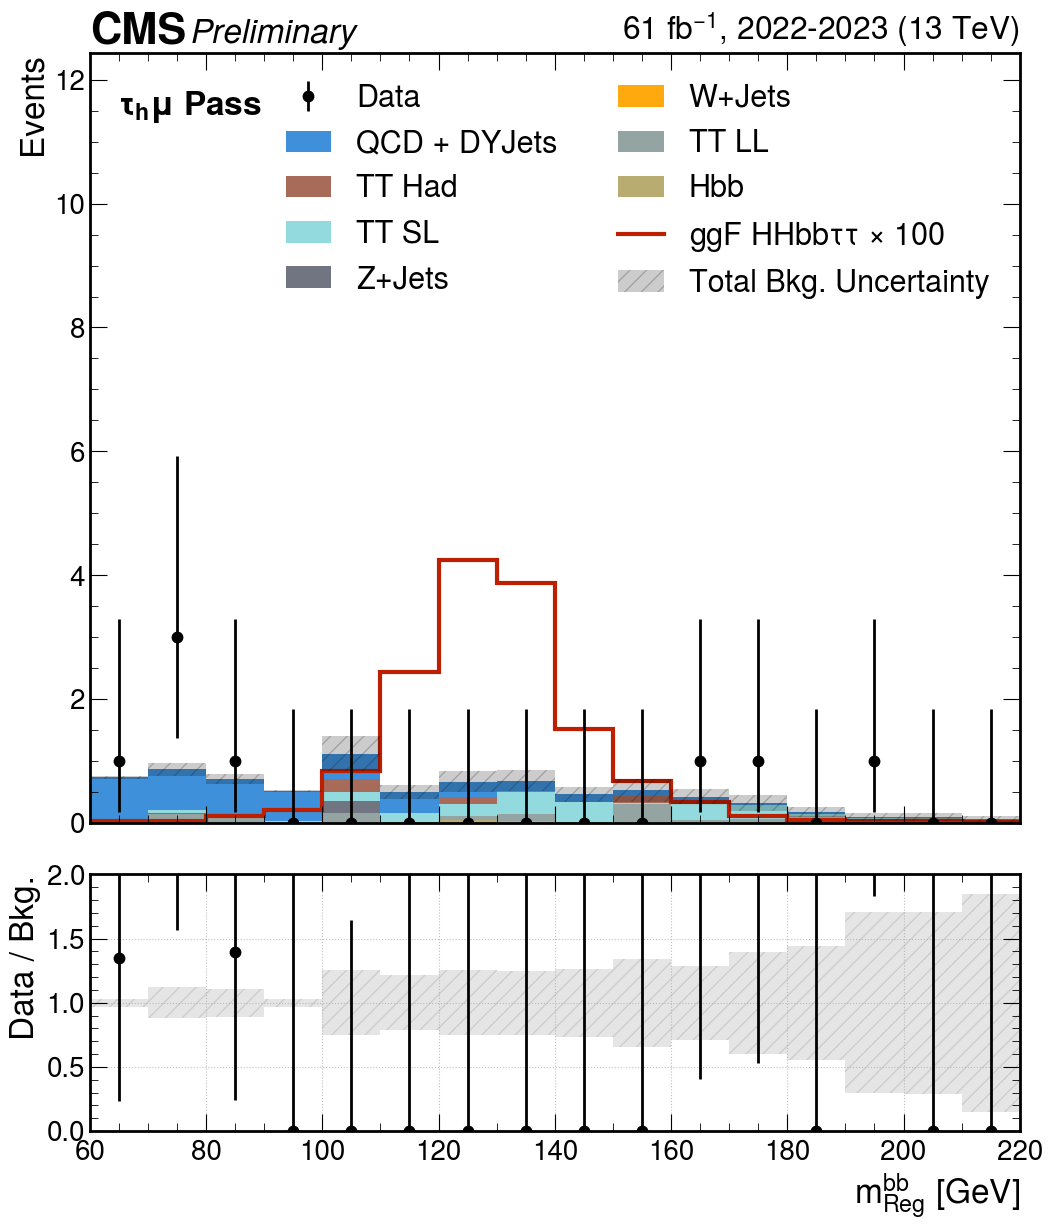

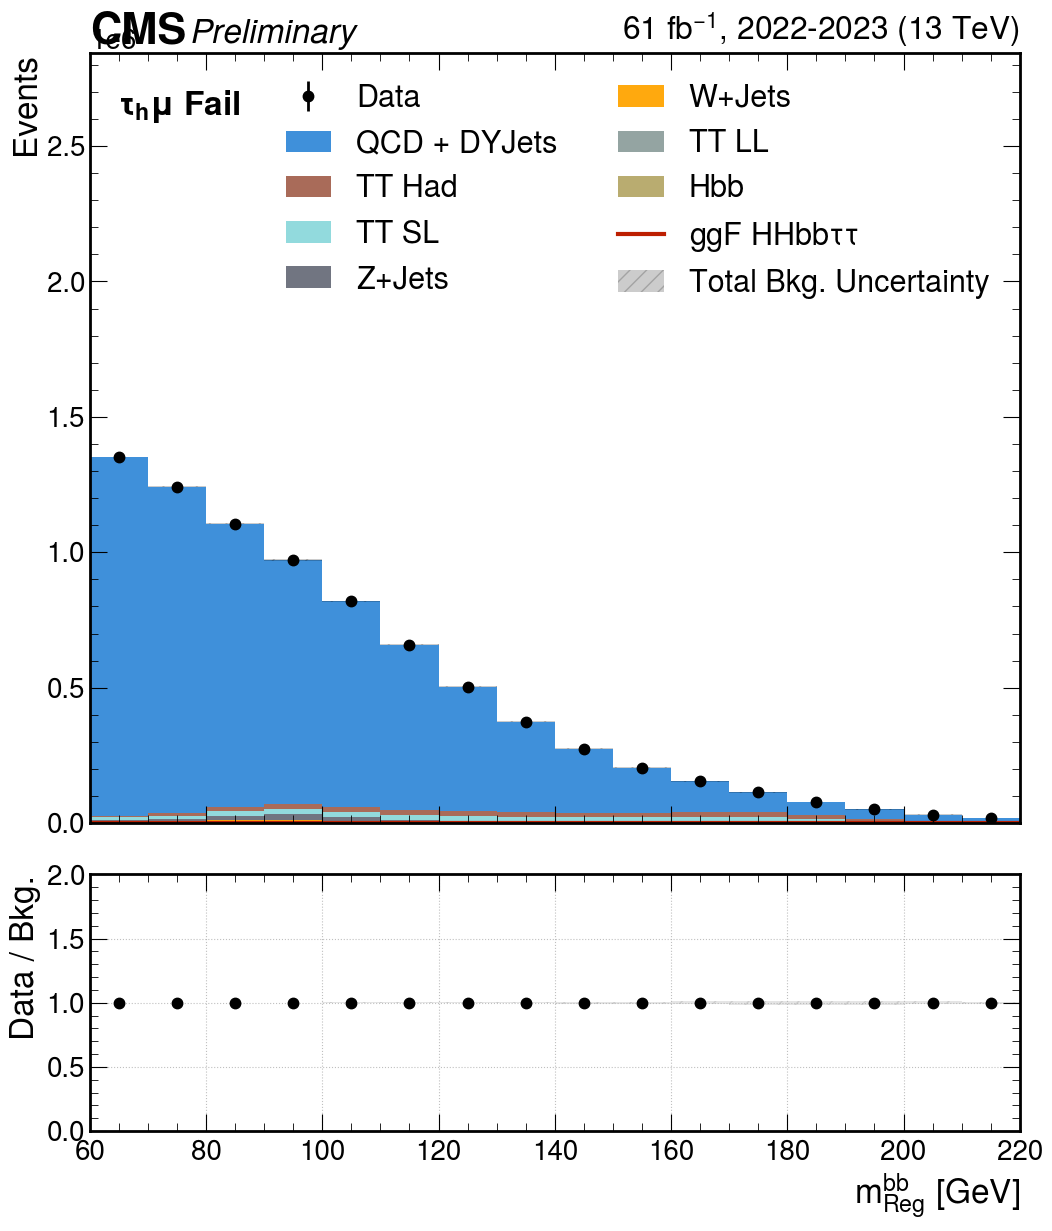

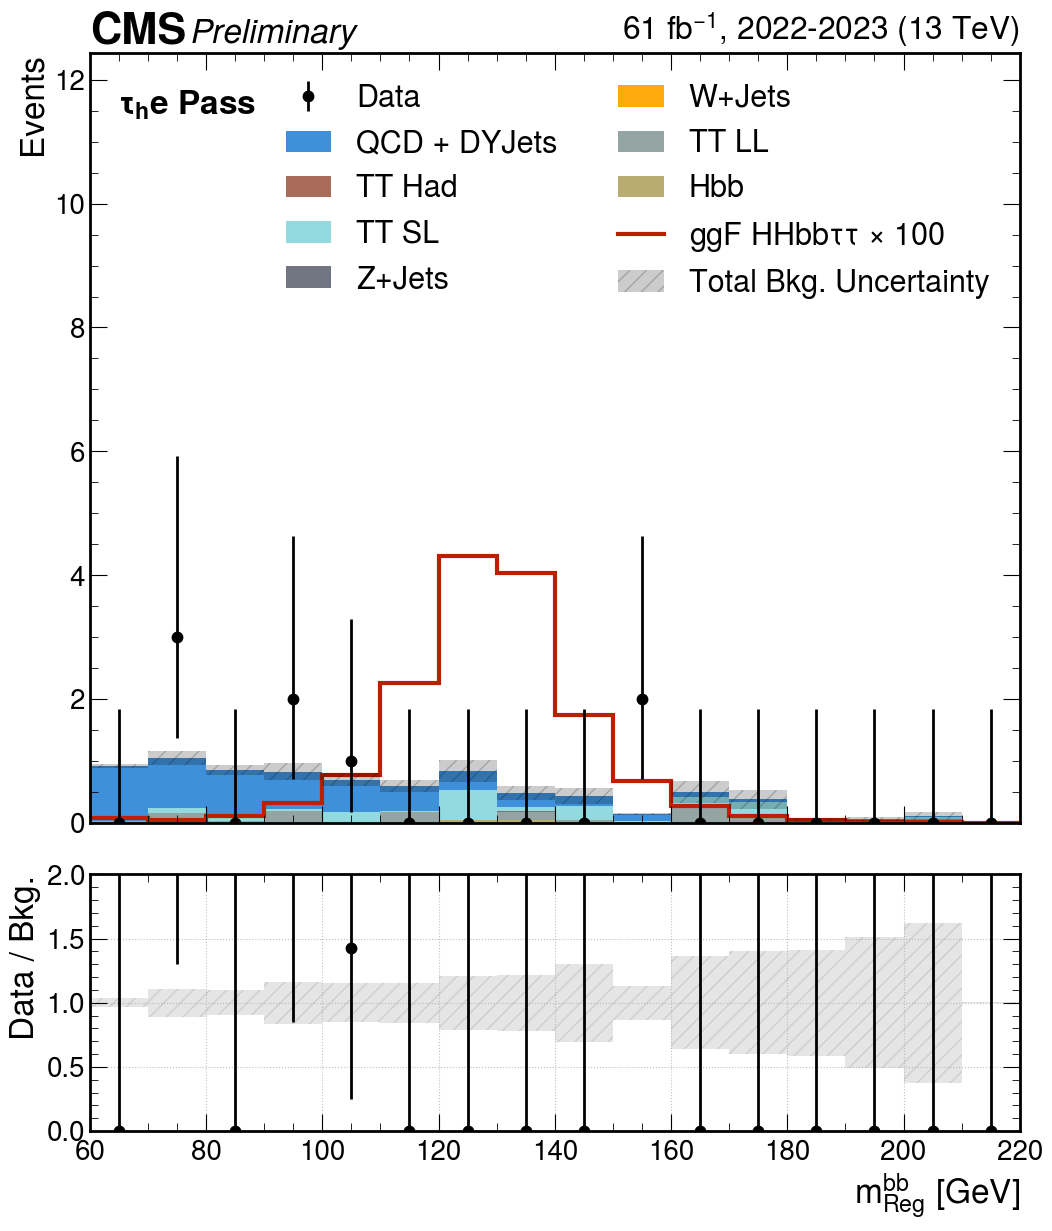

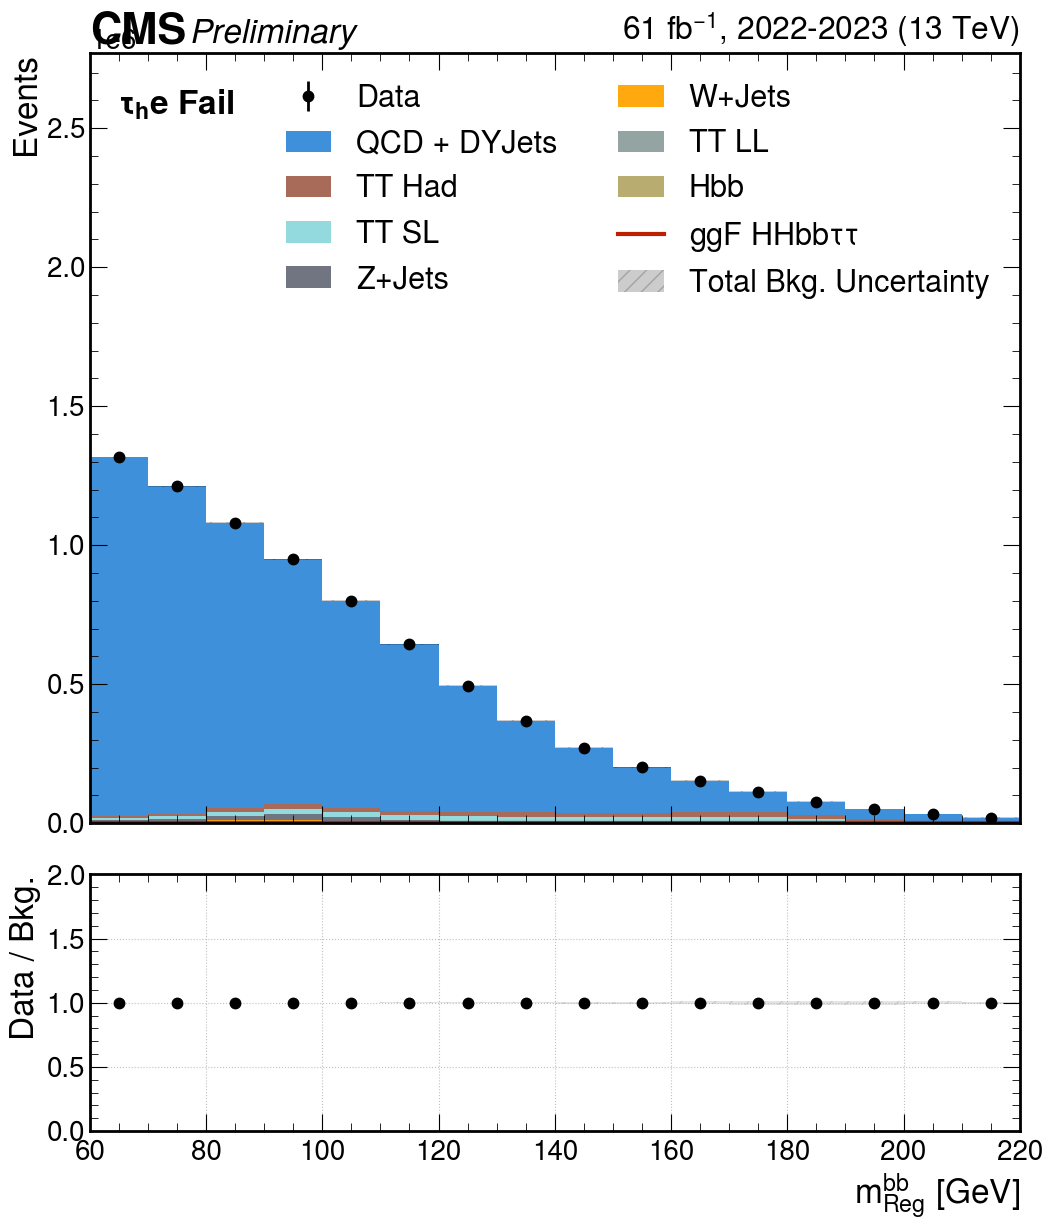

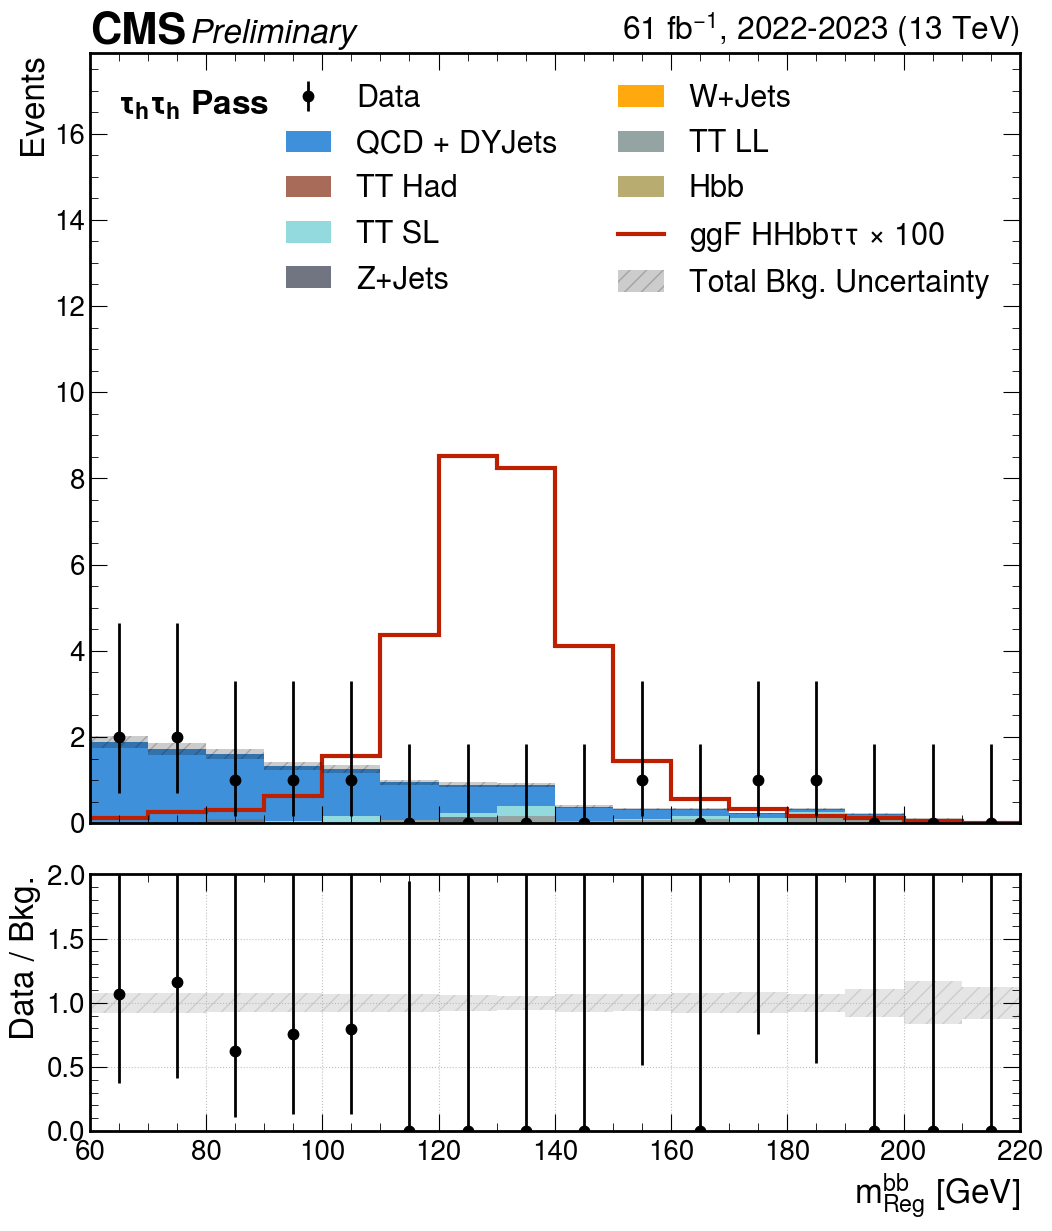

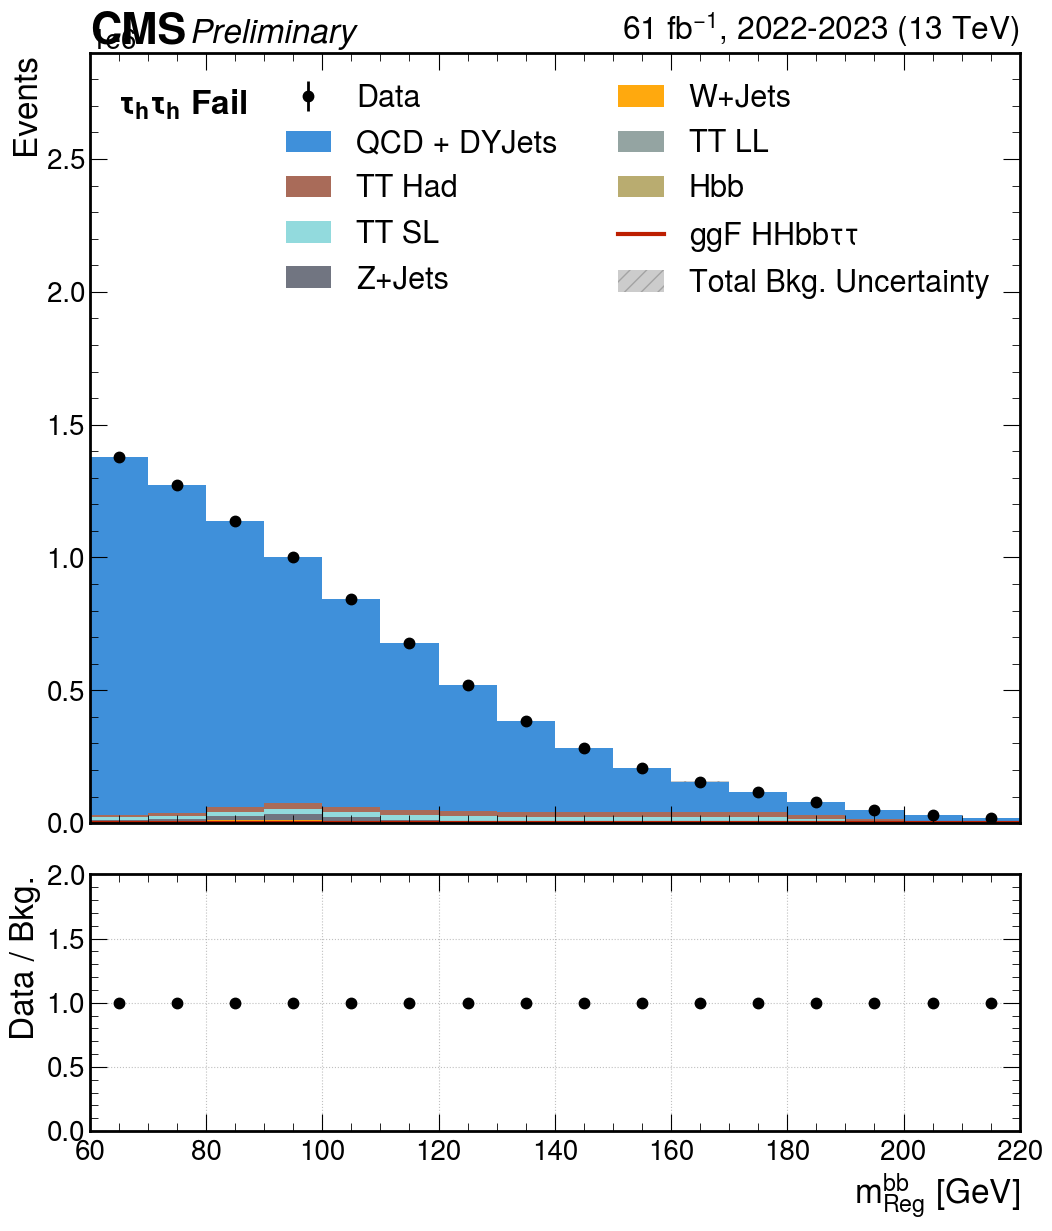

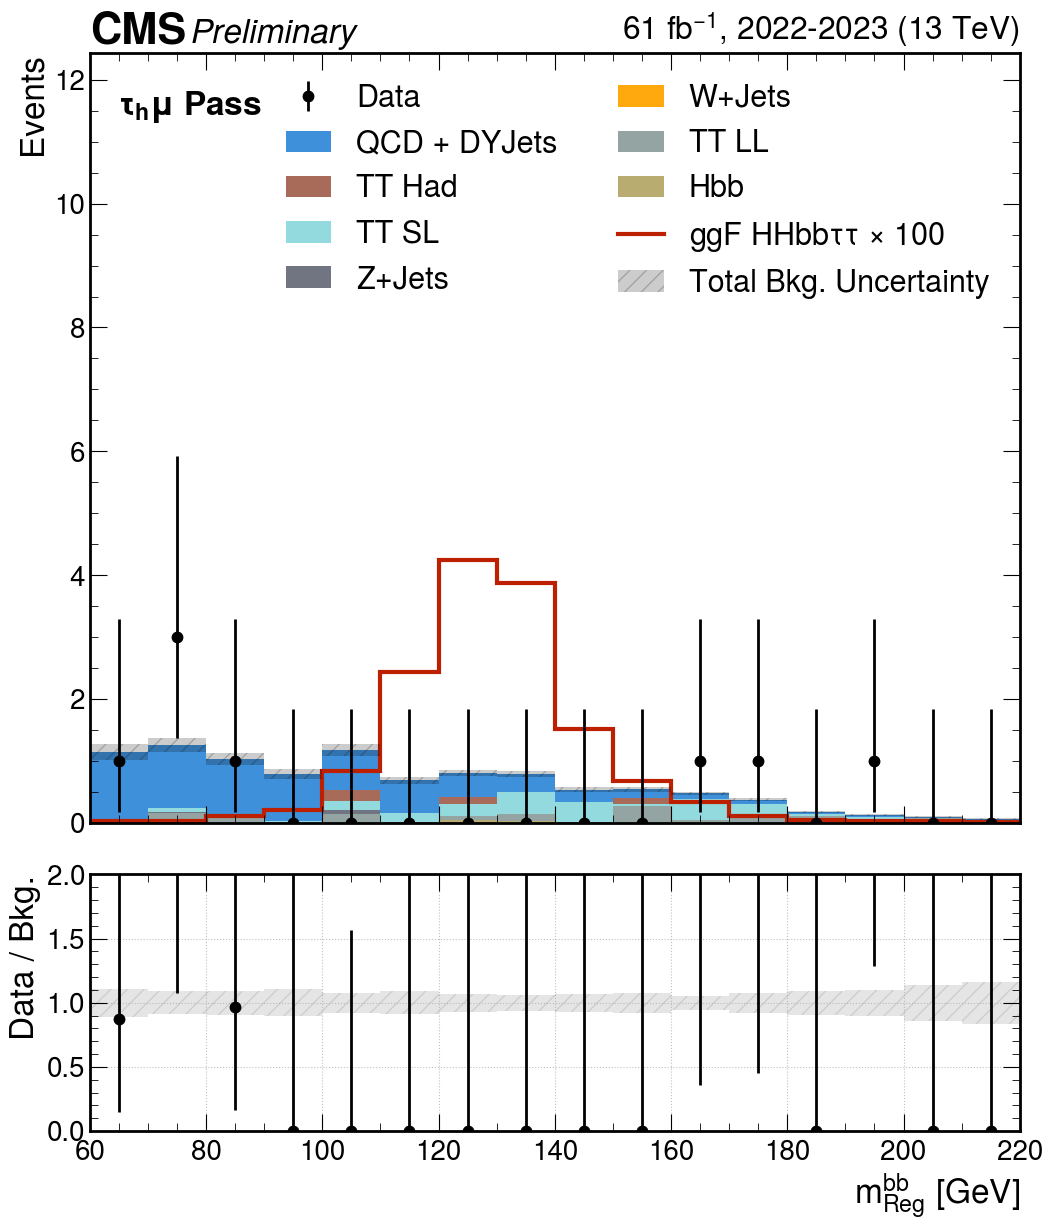

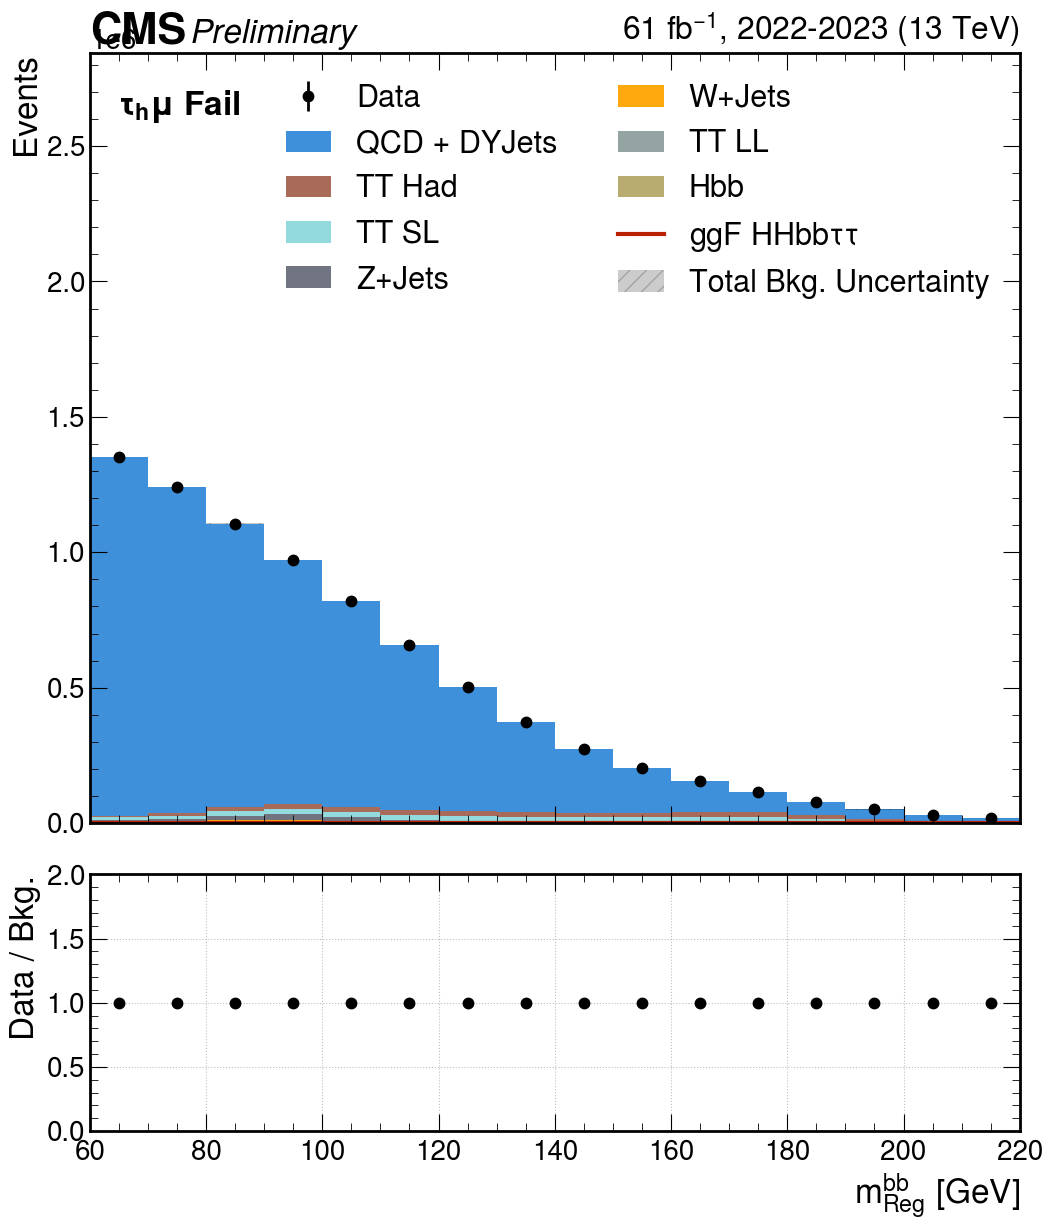

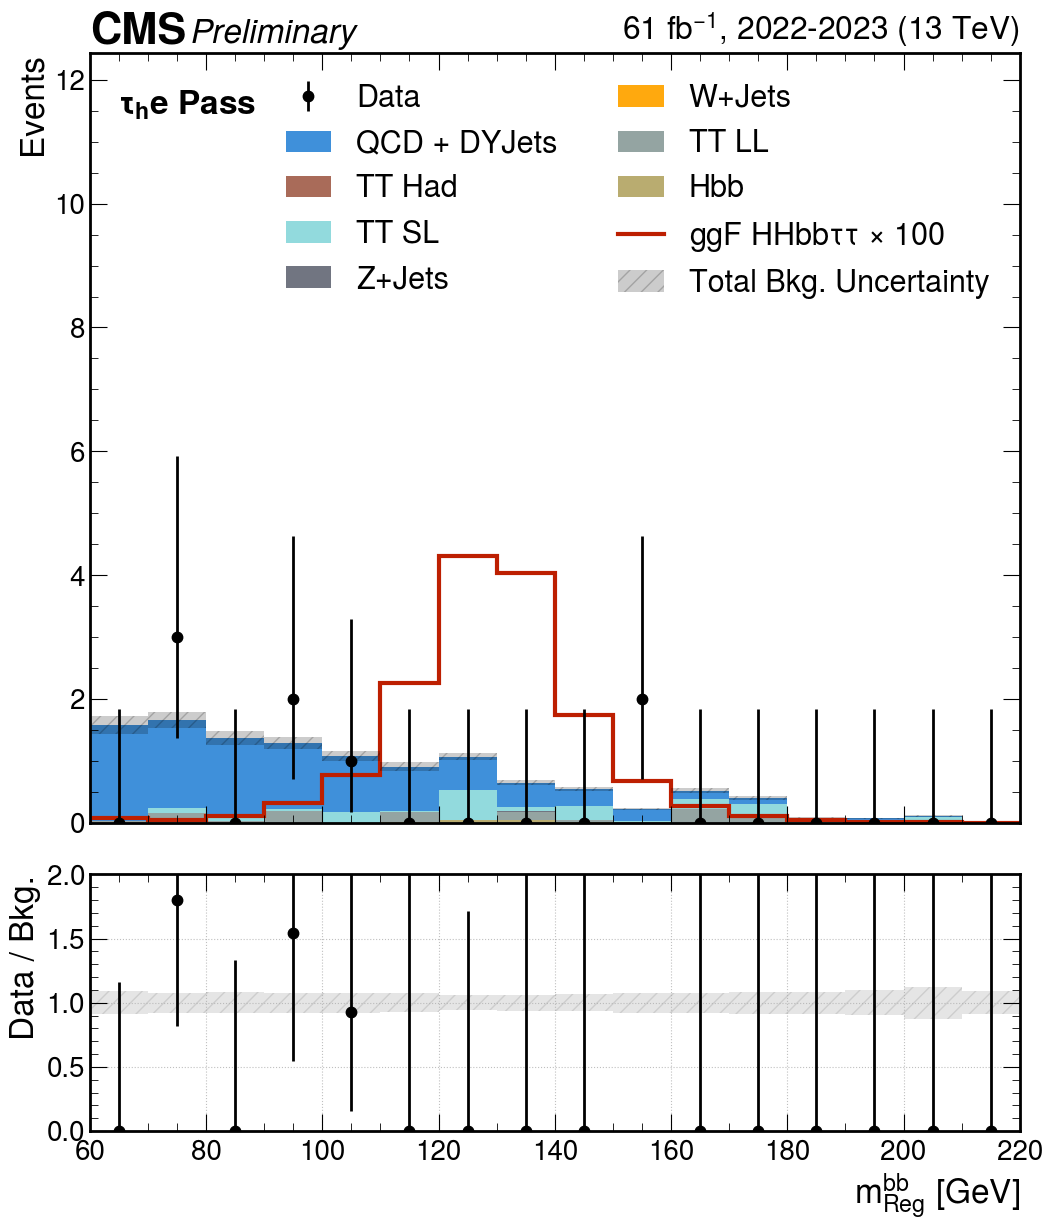

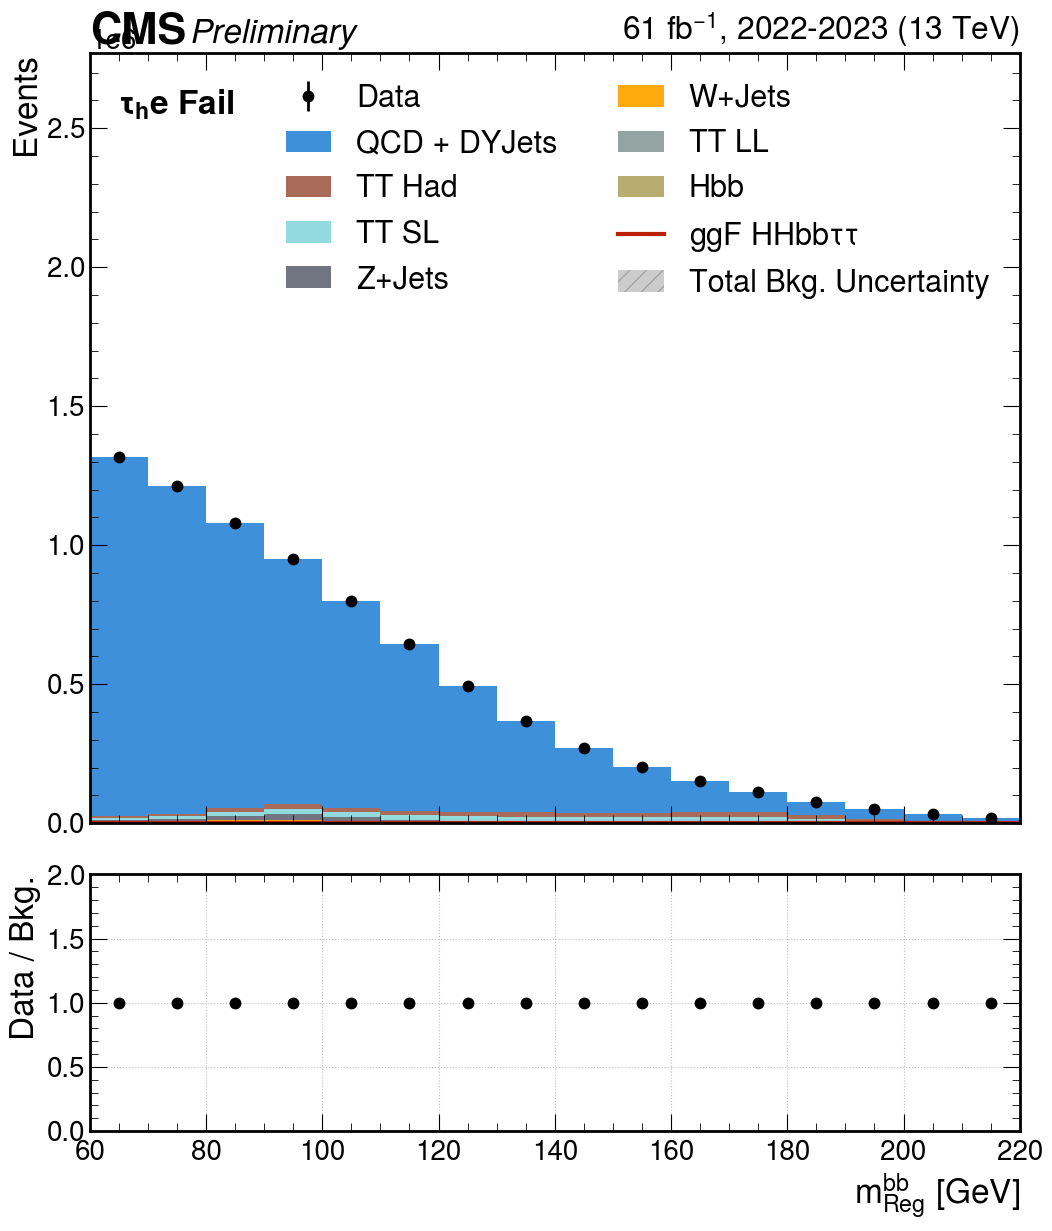

In [92]:
# ylims = {"hhpass": 1, "passvbf": 11, "fail": 7e5}
sig_scale_dict = {"bbtt": 100}

(plot_dir / "preliminary").mkdir(exist_ok=True, parents=True)
(plot_dir / "final").mkdir(exist_ok=True, parents=True)

for prelim, plabel, pplotdir in zip([True, False], ["Preliminary", ""], ["preliminary", "final"]):
    for shape, shape_label in shapes.items():
        # if shape != "postfit":
        #     continue
        for region, region_label in selection_regions.items():
            pass_region = "pass" in region
            for i, shape_var in enumerate(shape_vars):
                plot_params = {
                    "hists": hists[shape][region],
                    "sig_keys": sig_keys,
                    "bg_keys": pbg_keys,
                    "bg_err": bgerrs[shape][region],
                    "data_err": True,
                    "sig_scale_dict": sig_scale_dict if pass_region else None,
                    "show": True,
                    "year": "2022-2023",
                    # "ylim": ylims[region],
                    # "title": f"{shape_label} {region_label}",
                    "region_label": region_label,
                    "name": f"{plot_dir}/{pplotdir}/{pplotdir}_{shape}_{region}_{shape_var.var}.pdf",
                    "ratio_ylims": [0, 2],
                    "cmslabel": plabel,
                    "leg_args": {"fontsize": 22, "ncol": 2},
                    "channel": CHANNELS[region[:2]],
                }

                plotting.ratioHistPlot(**plot_params)

        # break
    break

## QCD Transfer Factor

In [ ]:
import matplotlib.ticker as mticker
import mplhep as hep

plt.style.use(hep.style.CMS)
hep.style.use("CMS")
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))

NameError: name 'jfdsikos' is not defined

                      ┌──────────────────────────────────────────────────────┐
[-inf,  60) -nan      │                                                      │
[  60,  70) 3.007e-06 │█████████████████████████████████████████████████████ │
[  70,  80) 3.007e-06 │█████████████████████████████████████████████████████ │
[  80,  90) 3.007e-06 │█████████████████████████████████████████████████████ │
[  90, 100) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 100, 110) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 110, 120) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 120, 130) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 130, 140) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 140, 150) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 150, 160) 3.007e-06 │█████████████████████████████████████████████████████ │
[ 160, 170) 3.007e-06 │█████████████████████████████

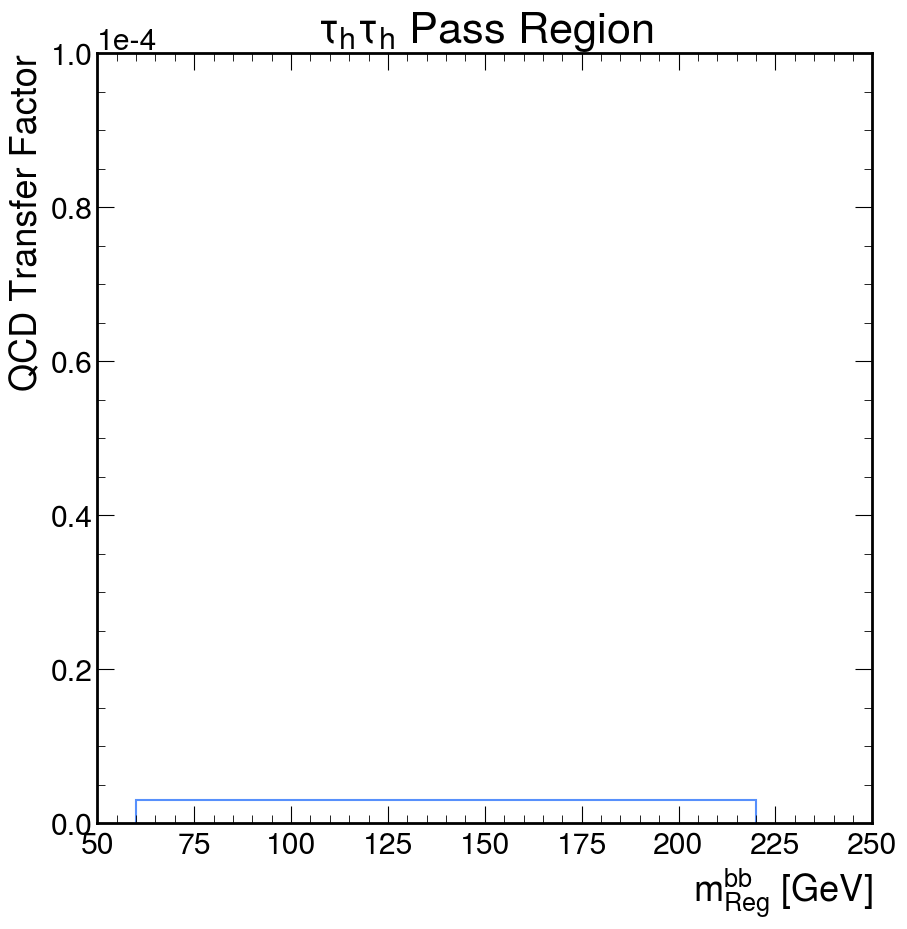

                 ┌───────────────────────────────────────────────────────────┐
[-inf,  60) -nan │                                                           │
[  60,  70) 1    │██████████████████████████████████████████████████████████ │
[  70,  80) 1    │██████████████████████████████████████████████████████████ │
[  80,  90) 1    │██████████████████████████████████████████████████████████ │
[  90, 100) 1    │██████████████████████████████████████████████████████████ │
[ 100, 110) 1    │██████████████████████████████████████████████████████████ │
[ 110, 120) 1    │██████████████████████████████████████████████████████████ │
[ 120, 130) 1    │██████████████████████████████████████████████████████████ │
[ 130, 140) 1    │██████████████████████████████████████████████████████████ │
[ 140, 150) 1    │██████████████████████████████████████████████████████████ │
[ 150, 160) 1    │██████████████████████████████████████████████████████████ │
[ 160, 170) 1    │██████████████████████████████████

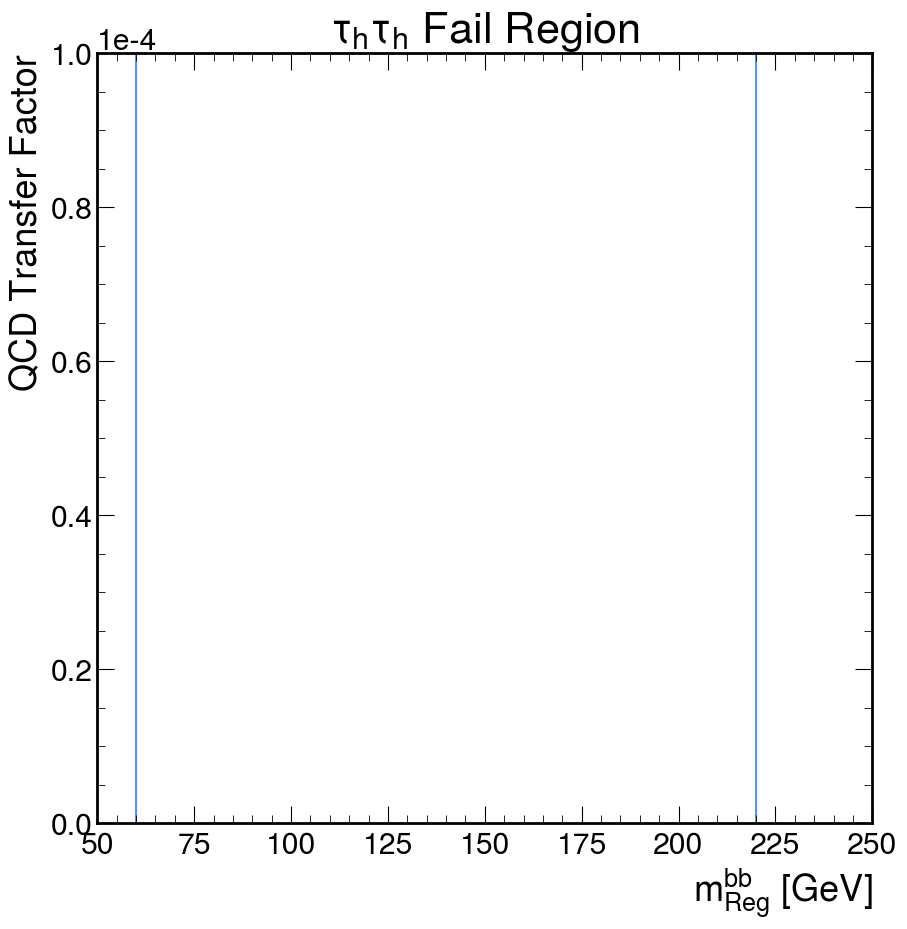

                      ┌──────────────────────────────────────────────────────┐
[-inf,  60) -nan      │                                                      │
[  60,  70) 2.332e-06 │█████████████████████████████████████████████████████ │
[  70,  80) 2.332e-06 │█████████████████████████████████████████████████████ │
[  80,  90) 2.332e-06 │█████████████████████████████████████████████████████ │
[  90, 100) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 100, 110) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 110, 120) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 120, 130) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 130, 140) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 140, 150) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 150, 160) 2.332e-06 │█████████████████████████████████████████████████████ │
[ 160, 170) 2.332e-06 │█████████████████████████████

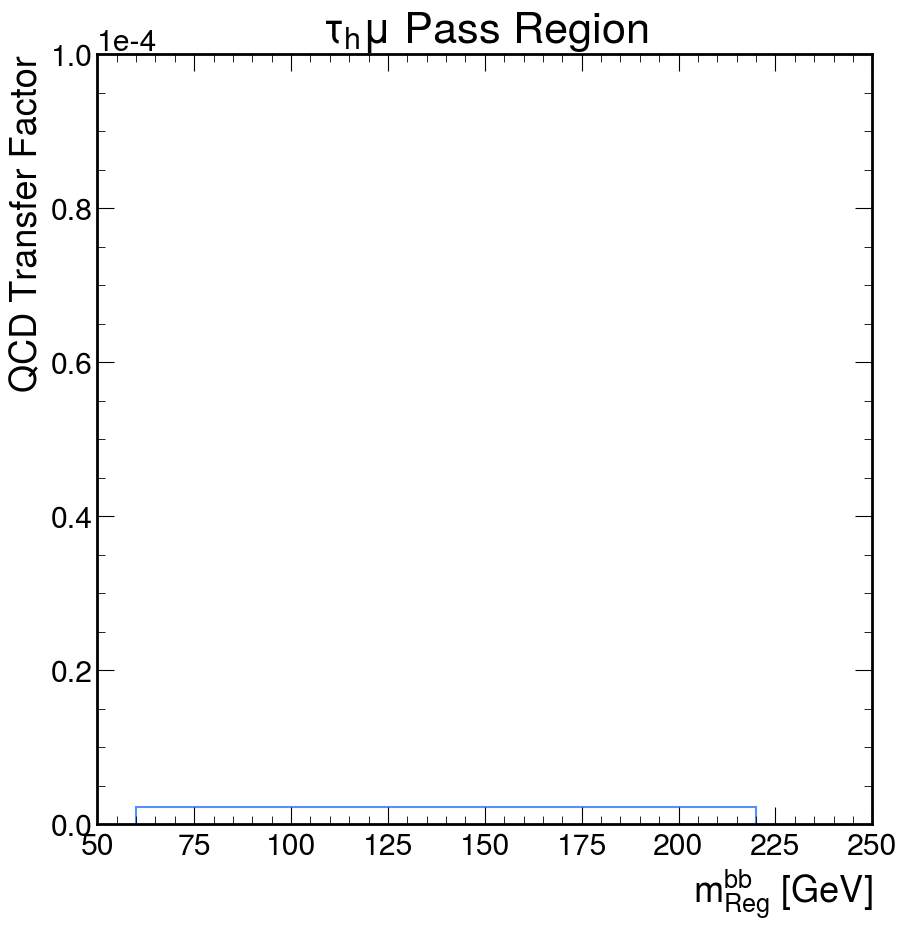

                 ┌───────────────────────────────────────────────────────────┐
[-inf,  60) -nan │                                                           │
[  60,  70) 1    │██████████████████████████████████████████████████████████ │
[  70,  80) 1    │██████████████████████████████████████████████████████████ │
[  80,  90) 1    │██████████████████████████████████████████████████████████ │
[  90, 100) 1    │██████████████████████████████████████████████████████████ │
[ 100, 110) 1    │██████████████████████████████████████████████████████████ │
[ 110, 120) 1    │██████████████████████████████████████████████████████████ │
[ 120, 130) 1    │██████████████████████████████████████████████████████████ │
[ 130, 140) 1    │██████████████████████████████████████████████████████████ │
[ 140, 150) 1    │██████████████████████████████████████████████████████████ │
[ 150, 160) 1    │██████████████████████████████████████████████████████████ │
[ 160, 170) 1    │██████████████████████████████████

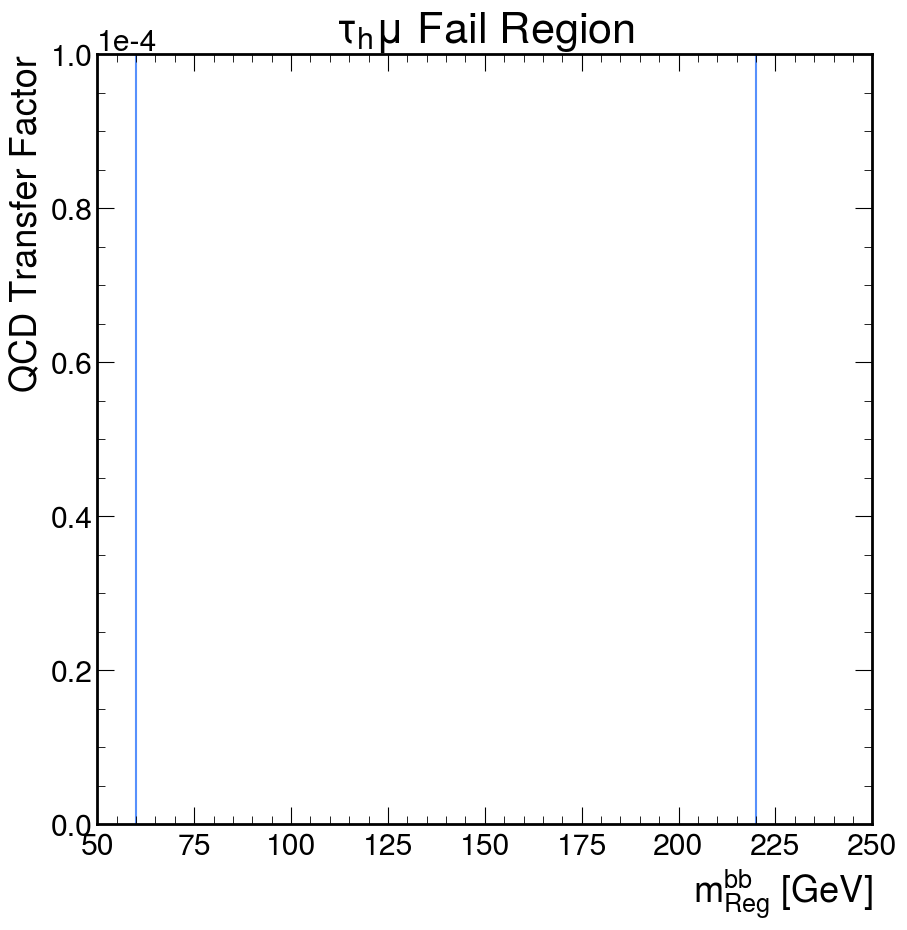

                      ┌──────────────────────────────────────────────────────┐
[-inf,  60) -nan      │                                                      │
[  60,  70) 4.372e-06 │█████████████████████████████████████████████████████ │
[  70,  80) 4.372e-06 │█████████████████████████████████████████████████████ │
[  80,  90) 4.372e-06 │█████████████████████████████████████████████████████ │
[  90, 100) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 100, 110) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 110, 120) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 120, 130) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 130, 140) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 140, 150) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 150, 160) 4.372e-06 │█████████████████████████████████████████████████████ │
[ 160, 170) 4.372e-06 │█████████████████████████████

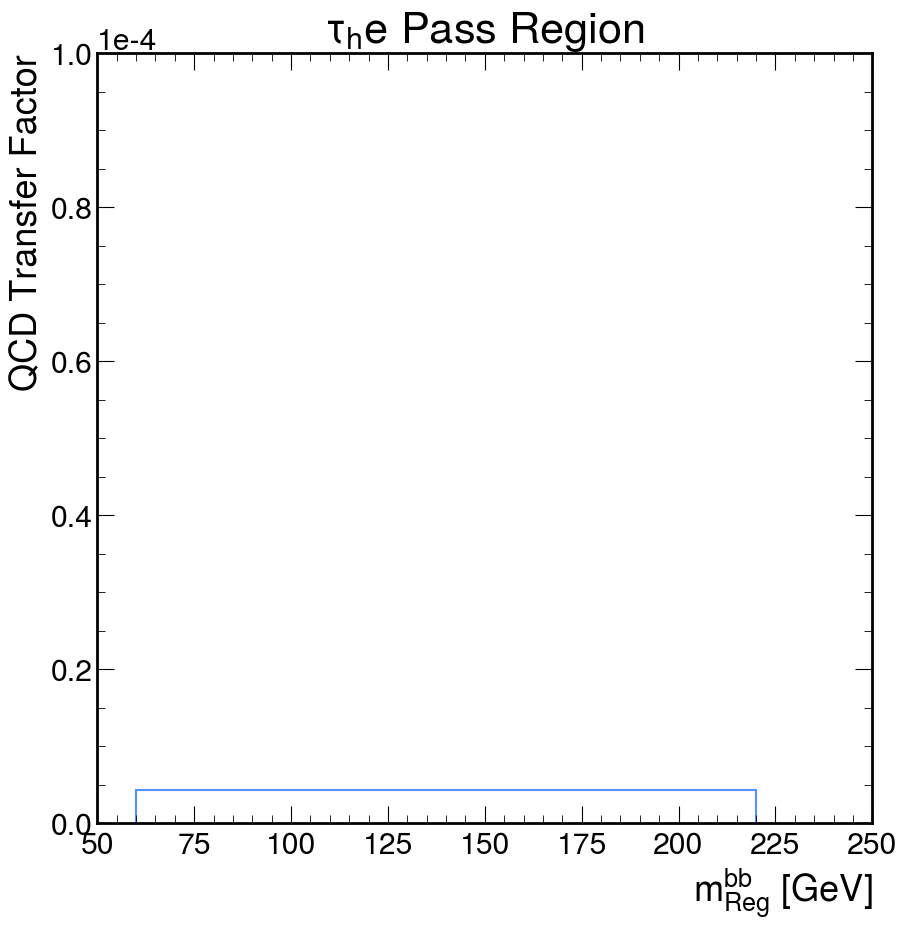

                 ┌───────────────────────────────────────────────────────────┐
[-inf,  60) -nan │                                                           │
[  60,  70) 1    │██████████████████████████████████████████████████████████ │
[  70,  80) 1    │██████████████████████████████████████████████████████████ │
[  80,  90) 1    │██████████████████████████████████████████████████████████ │
[  90, 100) 1    │██████████████████████████████████████████████████████████ │
[ 100, 110) 1    │██████████████████████████████████████████████████████████ │
[ 110, 120) 1    │██████████████████████████████████████████████████████████ │
[ 120, 130) 1    │██████████████████████████████████████████████████████████ │
[ 130, 140) 1    │██████████████████████████████████████████████████████████ │
[ 140, 150) 1    │██████████████████████████████████████████████████████████ │
[ 150, 160) 1    │██████████████████████████████████████████████████████████ │
[ 160, 170) 1    │██████████████████████████████████

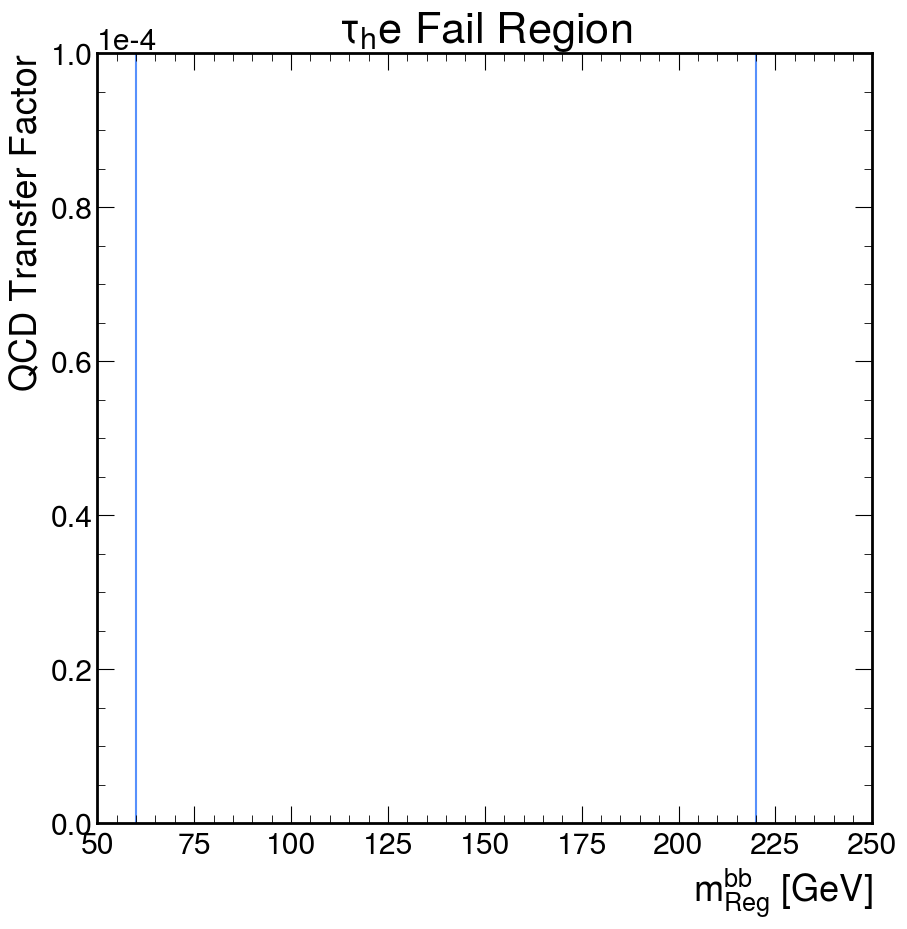

In [ ]:
ylims = {"passggf": 1e-4, "passvbf": 1e-5}
tfs = {}

for region, region_label in selection_regions.items():

    if region == "fail":
        continue

    tf = (
        hists["postfit"][region]["qcddy", ...] / hists["postfit"][region[:2] + "fail"]["qcddy", ...]
    )

    print(tf)

    tfs[region] = tf

    hep.histplot(tf)
    plt.title(f"{region_label} Region")
    plt.ylabel("QCD Transfer Factor")
    plt.xlim([50, 250])
    plt.ylim([0, 1e-4])
    plt.ticklabel_format(style="sci", axis="y", scilimits=(0, 0))
    # plt.savefig(f"{plot_dir}/{region}_QCDTF.pdf", bbox_inches="tight")
    plt.show()

In [ ]:
tf = tfs["passvbf"]
slope = (tf.view()[-1] - tf.view()[0]) / (245 - 55)
yint = tf.view()[0] - slope * 55
print(slope, yint)

KeyError: 'passvbf'